In [3]:
# !kaggle datasets download -d soumendraprasad/musical-instruments-sound-dataset

^C


In [ ]:
import zipfile
import os

# Path ke file ZIP dan direktori ekstraksi
zip_file_path = 'musical-instruments-sound-dataset.zip'
extract_dir = './musical_instruments_dataset'

# Membuat direktori ekstraksi jika belum ada
os.makedirs(extract_dir, exist_ok=True)

# Mengekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Ekstraksi selesai.")


In [2]:
%pip install resampy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import librosa

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import resampy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam

In [2]:
train_dir = 'musical_instruments_dataset\Train_submission'
test_dir = 'musical_instruments_dataset\Test_submission'
train_paths=[]
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        if filename[-4:]=='.wav':
            train_paths+=[(os.path.join(dirname, filename))]
test_paths=[]
tp_filename=[]
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        if filename[-4:]=='.wav':
            test_paths+=[(os.path.join(dirname, filename))]
            tp_filename+=[filename]

In [3]:
train_df=pd.read_csv('musical_instruments_dataset\Metadata_Train.csv')
test_df=pd.read_csv('musical_instruments_dataset\Metadata_Test.csv')

In [4]:
train_df

FileName         Class
0                   1-E1-Major 00.wav  Sound_Guitar
1                   1-E1-Major 01.wav  Sound_Guitar
2                   1-E1-Major 02.wav  Sound_Guitar
3                   1-E1-Major 03.wav  Sound_Guitar
4                   1-E1-Major 04.wav  Sound_Guitar
...                               ...           ...
2624          strange-piano-73881.wav   Sound_Piano
2625        the-last-piano-112677.wav   Sound_Piano
2626  this-is-war-version-e-95411.wav   Sound_Piano
2627     tired-ghosts-piano-65013.wav   Sound_Piano
2628              toy-piano-27311.wav   Sound_Piano

[2629 rows x 2 columns]

Class
Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: count, dtype: int64


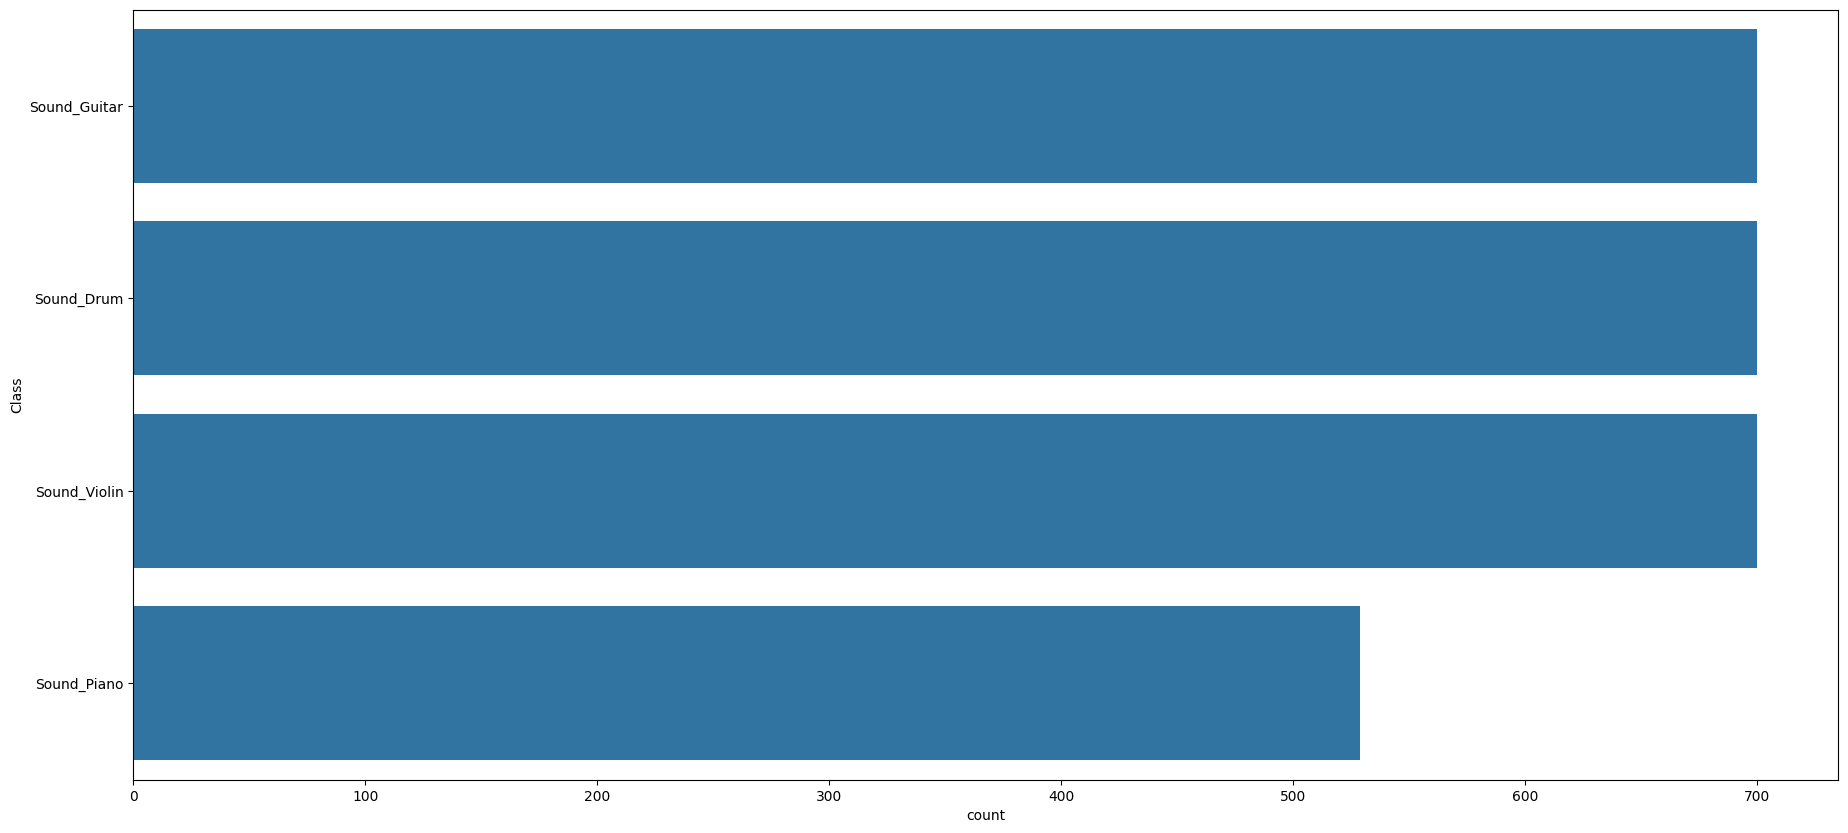

In [5]:
print(train_df['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(train_df['Class'])
plt.xticks(rotation=0)

plt.show()

In [ ]:
# Menampilkan nilai unik dari fitur 'Class'
unique_classes = train_df['Class'].unique()
print("Unique values in 'Class' feature:", unique_classes)

Class
Sound_Guiatr    20
Sound_Drum      20
Sound_Violin    20
Sound_Piano     20
Name: count, dtype: int64


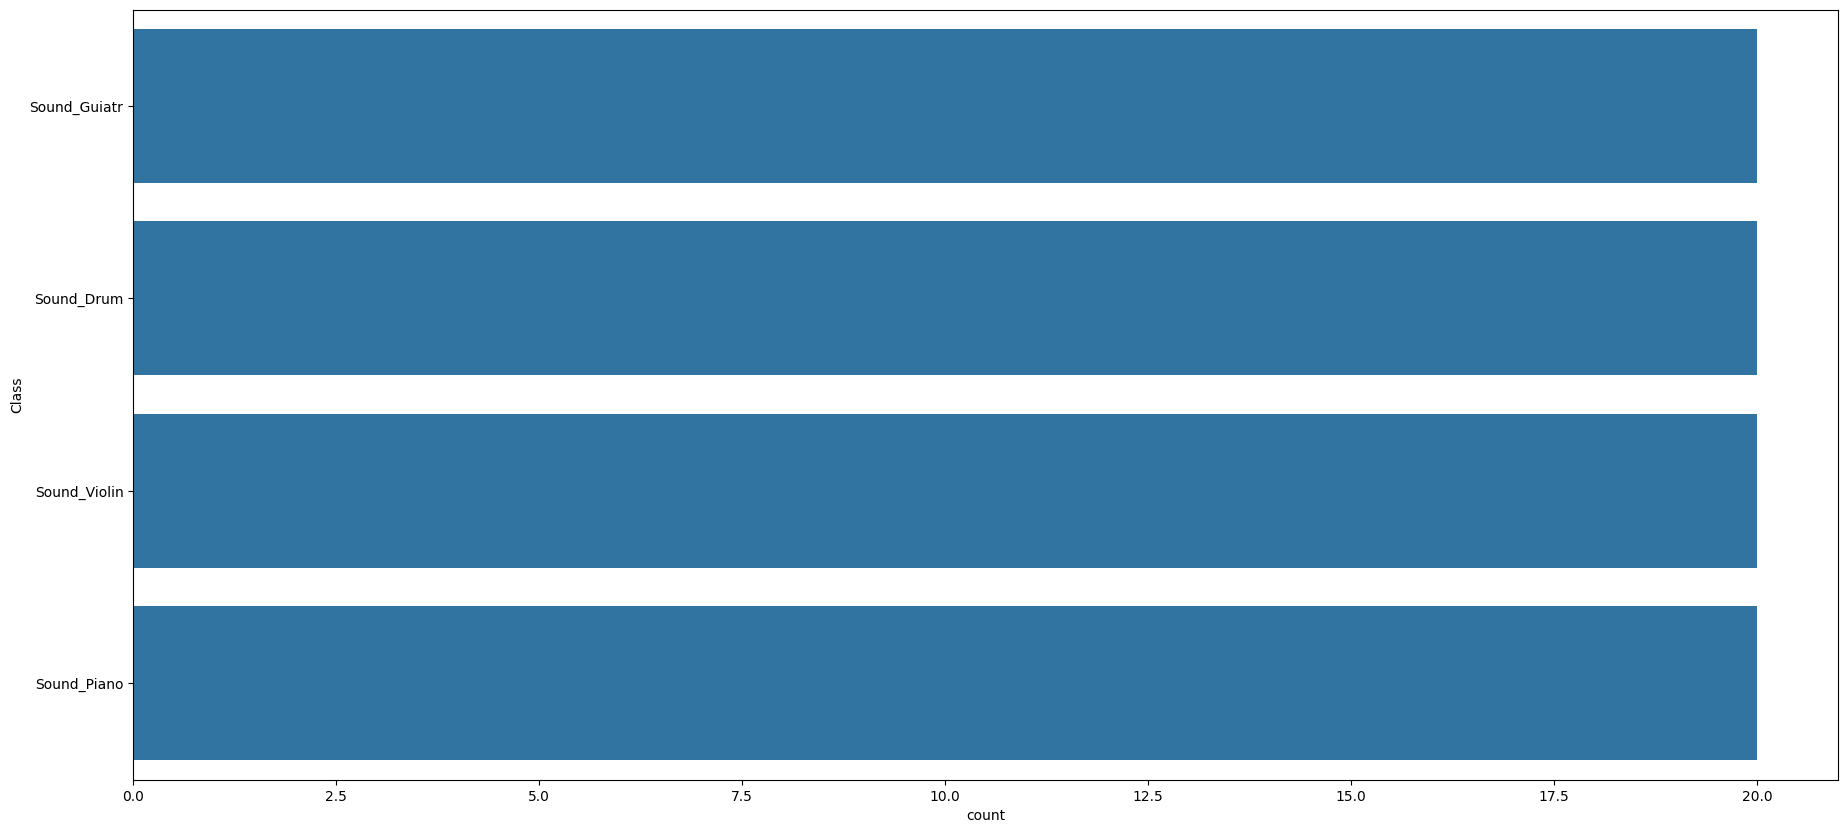

In [6]:
print(test_df['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(test_df['Class'])
plt.xticks(rotation=0)

plt.show()

In [7]:
train_df.set_index('FileName',inplace=True)

for f in train_df.index:
    rate, signal = wavfile.read('./musical_instruments_dataset/Train_submission/Train_submission/' + f)
    train_df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(train_df.Class))
class_dist = train_df.groupby(['Class'])['length'].mean()

C:\Users\Tazkiiia\AppData\Local\Temp\ipykernel_35428\3584132108.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read('./musical_instruments_dataset/Train_submission/Train_submission/' + f)
C:\Users\Tazkiiia\AppData\Local\Temp\ipykernel_35428\3584132108.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read('./musical_instruments_dataset/Train_submission/Train_submission/' + f)
C:\Users\Tazkiiia\AppData\Local\Temp\ipykernel_35428\3584132108.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read('./musical_instruments_dataset/Train_submission/Train_submission/' + f)
C:\Users\Tazkiiia\AppData\Local\Temp\ipykernel_35428\3584132108.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, signal = wavfile.read('./musical_instruments_dataset/Train_submission/Train_submission/' + f)
C:\Users\Tazkiiia\AppData\Local\Temp\ipykernel_35428\3584132108.

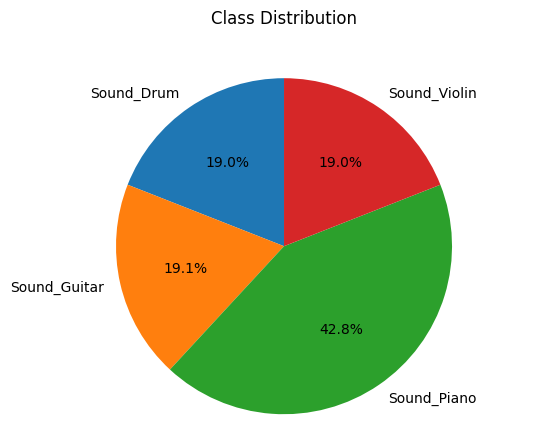

In [8]:
# Volume of each labels

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()
train_df.reset_index(inplace=True)

In [9]:
# Calculate FFT

def calc_fft(y,sr):

    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/sr)
    Y=abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [10]:
# Valuable Info In Sample

def Envelope(y, rate, threshold):
    mask = []
    #we want a rolling window so we create series as it is easy with it
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/4), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)

    return mask

In [11]:
# Taking One Audio from each class
# Applying some FE methods

signals = {}
fft = {}
fnames=[]
mfccs = {}


for c in classes:
    wav_file = train_df[train_df.Class == c].iloc[0,0]
    fnames.append('./musical_instruments_dataset//Train_submission/Train_submission/'+wav_file)
    signal, rate = librosa.load('./musical_instruments_dataset//Train_submission/Train_submission/'+wav_file,sr=44100)
    mask = Envelope(signal, rate, 0.0005) #0.0005 is experimental
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)


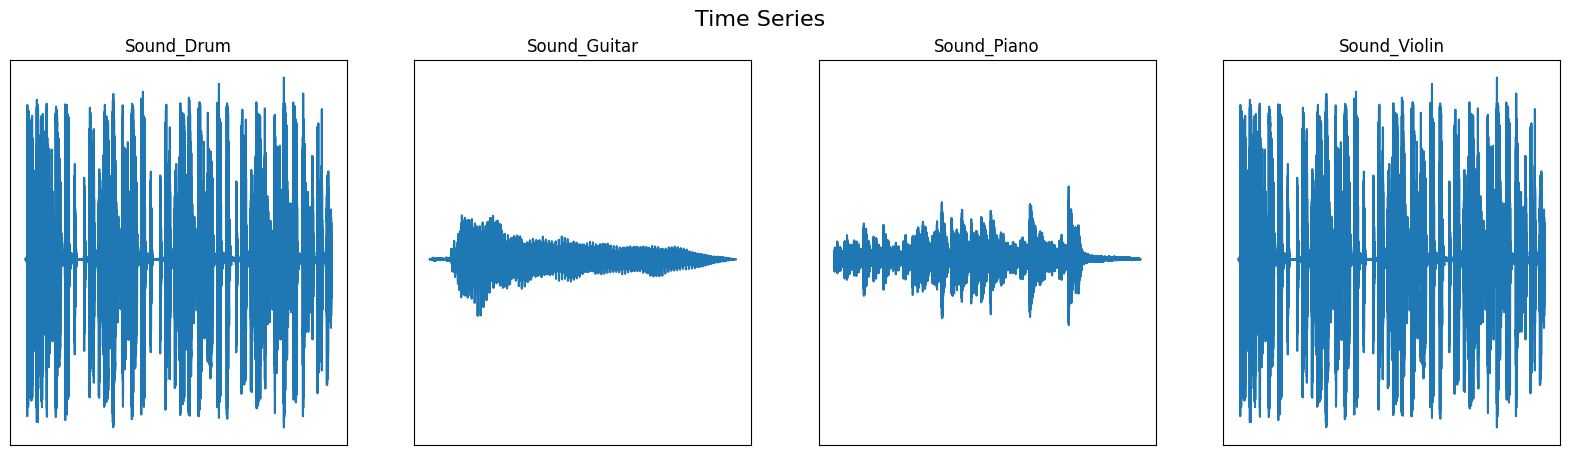

In [12]:
# Plotting Signals

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(4):
            axes[x].set_title(list(signals.keys())[i])
            axes[x].plot(list(signals.values())[i])
            axes[x].get_xaxis().set_visible(False)
            axes[x].get_yaxis().set_visible(False)
            i += 1
plot_signals(signals)
plt.show()

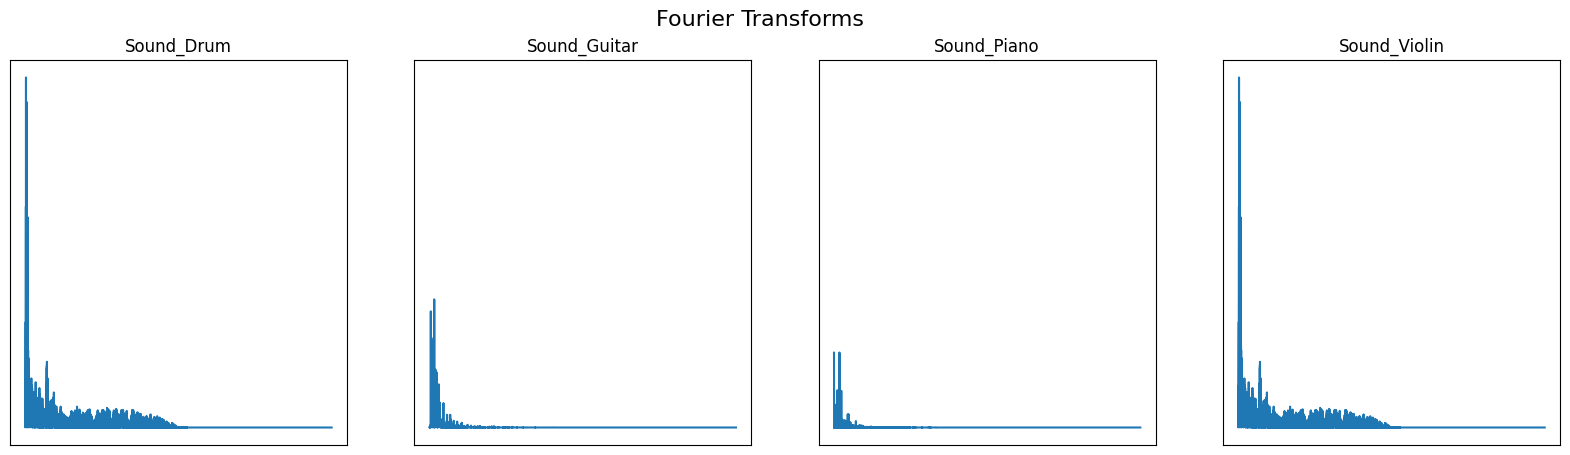

In [13]:
# Plotting ffts

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(4):

            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x].set_title(list(fft.keys())[i])
            axes[x].plot(freq, Y)
            axes[x].get_xaxis().set_visible(False)
            axes[x].get_yaxis().set_visible(False)
            i += 1
plot_fft(fft)
plt.show()

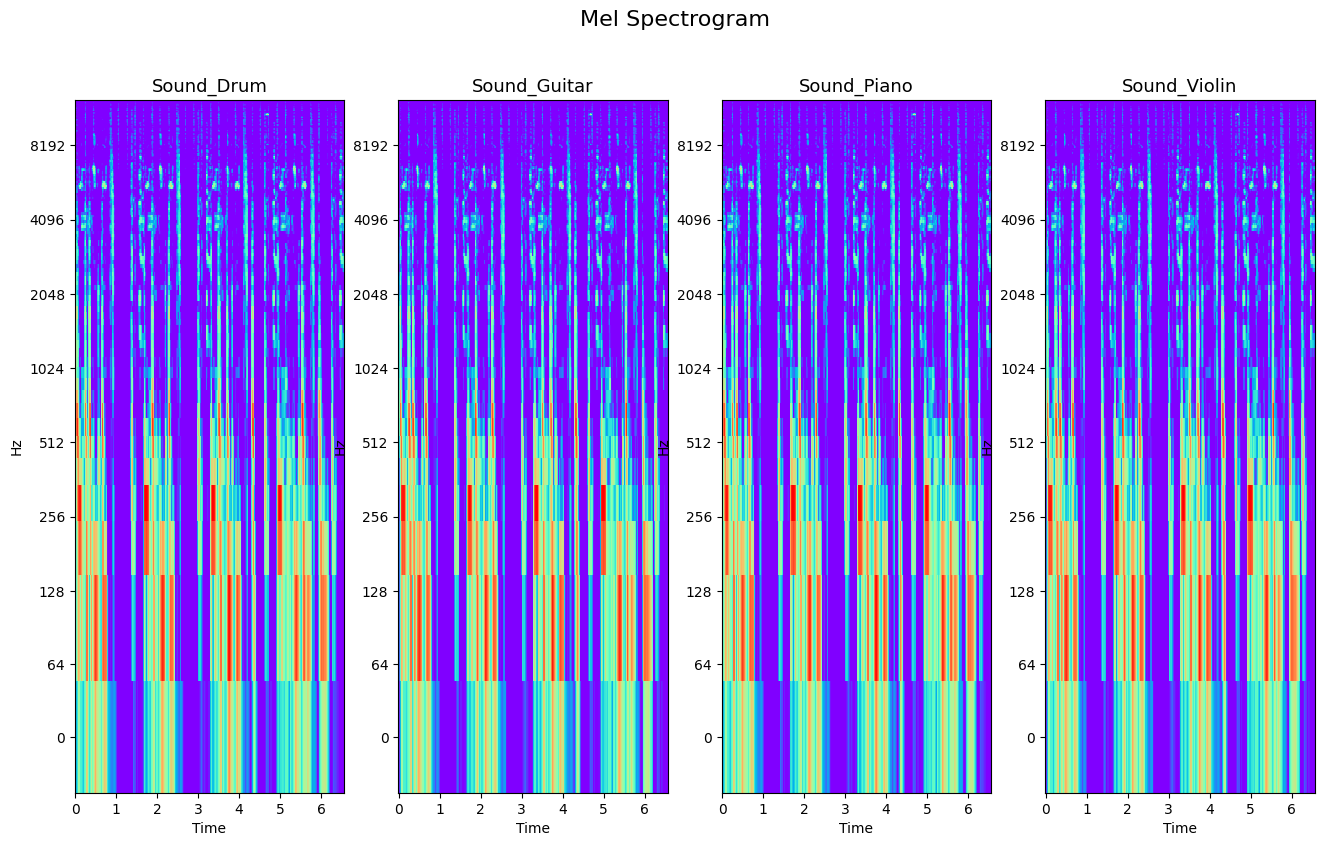

In [14]:
# Mel Spectograms

data = []
hop_length = 512
ename = list(signals.keys())

for i in fnames:
    y_data, sr_data = librosa.load(fnames[0])
    data.append(y_data)

# Compute Mel spectrograms for each audio signal
mel_spectrograms = []
for y_data in data:
    mel_spec = librosa.feature.melspectrogram(y=y_data, sr=25000)
    S = librosa.amplitude_to_db(mel_spec, ref=np.max)
    mel_spectrograms.append(S)

# Plot Mel spectrograms
fig, ax = plt.subplots(1, len(data), figsize=(16, 9))
fig.suptitle('Mel Spectrogram', fontsize=16)

for i, (S, name) in enumerate(zip(mel_spectrograms, ename)):
    librosa.display.specshow(S, sr=25000, hop_length=hop_length, x_axis='time',
                             y_axis='log', cmap='rainbow', ax=ax[i % len(data)])
    ax[i % len(data)].set_title(name, fontsize=13)

plt.show()

In [15]:
import os

# Membuat folder 'spectrogram' jika belum ada
if not os.path.exists('spectrogram'):
    os.makedirs('spectrogram')

# Menyimpan Mel spectrograms dalam format PNG
for i, (S, name) in enumerate(zip(mel_spectrograms, ename)):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S, sr=25000, hop_length=hop_length, x_axis='time',
                             y_axis='log', cmap='rainbow')
    plt.title(name, fontsize=13)
    plt.colorbar(format='%+2.0f dB')
    plt.savefig(f'spectrogram/{name}.png')
    plt.close()


In [16]:
from tqdm import tqdm

def Feature_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_scaled = np.mean(zcr.T, axis=0).reshape(1, -1)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    spectral_centroid_scaled = np.mean(spectral_centroid.T, axis=0).reshape(1, -1)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    spectral_bandwidth_scaled = np.mean(spectral_bandwidth.T, axis=0).reshape(1, -1)

    # Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    chroma_stft_scaled = np.mean(chroma_stft.T, axis=0).reshape(1, -1)

    # Root Mean Square Energy (RMSE)
    rmse = librosa.feature.rms(y=audio)
    rmse_scaled = np.mean(rmse.T, axis=0).reshape(1, -1)

    # Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    spectral_contrast_scaled = np.mean(spectral_contrast.T, axis=0).reshape(1, -1)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0).reshape(1, -1)

    # Combine all features into a single array
    features = np.concatenate([zcr_scaled, spectral_centroid_scaled, spectral_bandwidth_scaled,
                               chroma_stft_scaled, rmse_scaled, spectral_contrast_scaled, mfccs_scaled], axis=1)

    return features

In [17]:
%pip show resampy

Name: resampy
Version: 0.4.3
Summary: Efficient signal resampling
Home-page: https://github.com/bmcfee/resampy
Author: Brian McFee
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: c:\users\tazkiiia\appdata\local\programs\python\python310\lib\site-packages
Requires: numba, numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install --upgrade librosa

Note: you may need to restart the kernel to use updated packages.


In [19]:
extracted_features = []  # Simpan semua fitur dalam list
labels = []  # Simpan label kelas

for index_num, row in tqdm(train_df.iterrows()):
    file_name = os.path.join(os.path.abspath('./musical_instruments_dataset/Train_submission/Train_submission/'), str(row["FileName"]))
    final_class_label = row["Class"]

    features = Feature_extractor(file_name)
    extracted_features.append(features)
    labels.append(final_class_label)

# Menggabungkan semua fitur menjadi satu array dua dimensi
features_array = np.vstack(extracted_features)



718it [02:55,  3.49it/s]c:\Users\Tazkiiia\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
2629it [13:29,  3.25it/s]


In [20]:
# Membuat DataFrame dari array fitur
columns = ['zcr', 'spectral_centroid', 'spectral_bandwidth'] + \
          [f'chroma_stft_{i}' for i in range(12)] + \
          ['rmse'] + \
          [f'spectral_contrast_{i}' for i in range(7)] + \
          [f'mfcc_{i}' for i in range(40)]

extracted_features_df = pd.DataFrame(features_array, columns=columns)

# Menambahkan kolom label
extracted_features_df['label'] = labels

extracted_features_df.head(20)

zcr  spectral_centroid  spectral_bandwidth  chroma_stft_0  \
0   0.033610         565.569407          733.488991       0.276383   
1   0.031295         608.544068          801.422666       0.812041   
2   0.037240         694.521508          896.356303       0.313433   
3   0.033994         587.360890          789.244431       0.124576   
4   0.037548         643.731890          836.660030       0.904457   
5   0.031670         582.018264          786.691313       0.340923   
6   0.028528         553.543979          757.504741       0.100525   
7   0.031960         585.807403          780.984572       0.196493   
8   0.029966         608.090753          853.528102       0.467911   
9   0.031096         649.913621          859.386394       0.160544   
10  0.032516         607.843465          766.817246       0.065347   
11  0.032597         581.606086          761.404417       0.408490   
12  0.030427         565.671641          786.500571       0.857616   
13  0.028216         530.249414          736.374515       0.215056   
14  0.033022         587.426941          798.757135       0.040199   
15  0.030319         578.229428          790.788712       0.238834   
16  0.032841         574.666647          778.115089       0.957205   
17  0.029446         573.129911          801.833020       0.357929   
18  0.029338         561.939861          764.952305       0.233450   
19  0.031340         558.563814          723.602036       0.537810   

    chroma_stft_1  chroma_stft_2  chroma_stft_3  chroma_stft_4  chroma_stft_5  \
0        0.079381       0.113522       0.445338       0.890764       0.353598   
1        0.412074       0.130997       0.134158       0.392757       0.832325   
2        0.885059       0.339328       0.091868       0.136668       0.436041   
3        0.211564       0.855348       0.346609       0.058486       0.073991   
4        0.270108       0.229153       0.749980       0.264549       0.073734   
5        0.914943       0.247283       0.204435       0.516529       0.217354   
6        0.186078       0.896254       0.434074       0.227844       0.728121   
7        0.057225       0.274442       0.923740       0.267851       0.219634   
8        0.214390       0.081222       0.294802       0.923878       0.236023   
9        0.434529       0.217179       0.071891       0.188764       0.912827   
10       0.318942       0.753981       0.393691       0.084313       0.203280   
11       0.127117       0.245092       0.294769       0.764053       0.420158   
12       0.526565       0.132222       0.128108       0.277667       0.783859   
13       0.832910       0.366199       0.119120       0.216862       0.424314   
14       0.233426       0.749956       0.243163       0.057176       0.117760   
15       0.036741       0.210070       0.661745       0.248104       0.054677   
16       0.393642       0.045726       0.160687       0.628836       0.259107   
17       0.956512       0.246042       0.059309       0.284510       0.655578   
18       0.259465       0.921052       0.350420       0.044173       0.158143   
19       0.202875       0.299515       0.905351       0.255578       0.046800   

    chroma_stft_6  ...    mfcc_31    mfcc_32    mfcc_33    mfcc_34    mfcc_35  \
0        0.199829  ... -16.175524   1.599572  11.936126   4.351582  -7.551958   
1        0.368835  ...  12.491045   8.432343 -15.826512 -33.135807 -21.442444   
2        0.892124  ... -16.751749 -26.957222 -26.907324  -8.638338  19.134167   
3        0.269304  ... -32.380344  -8.330529  10.236014  19.660471   3.035672   
4        0.114579  ...   6.270214  18.269333   9.162492  -2.378100 -21.231279   
5        0.057142  ...  20.802073  -2.569783 -28.514893 -29.423941 -14.618137   
6        0.348551  ... -20.153059 -37.719311 -27.083887  -5.810862   1.108178   
7        0.632938  ... -48.970989 -19.738813   0.547929   2.098346  -4.556175   
8        0.219071  ... -21.573189  10.401426   3.673964  -7.789071   4.366257   
9        0.312740  ...  23

In [21]:
extracted_features_df.to_csv('extracted_features.csv', index=False)


In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# Label encoding
label_encoder = LabelEncoder()
extracted_features_df['label'] = label_encoder.fit_transform(extracted_features_df['label'])

# Memisahkan fitur dan label
X = extracted_features_df.drop('label', axis=1)
y = extracted_features_df['label']

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Simpan scaler dan label encoder
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Memeriksa dimensi data
print("Dimensi X_train:", X_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi y_train:", y_train.shape)
print("Dimensi y_test:", y_test.shape)

num_labels = len(extracted_features_df['label'].unique())
print("Jumlah label:", num_labels)


Dimensi X_train: (2103, 63)
Dimensi X_test: (526, 63)
Dimensi y_train: (2103,)
Dimensi y_test: (526,)
Jumlah label: 4


In [23]:
X.shape

(2629, 63)

In [24]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_labels)
y_test_encoded = to_categorical(y_test, num_labels)

In [25]:
# Creating Our Model
from keras.layers import LSTM

# Membuat model
model = Sequential()
model.add(LSTM(units=256, input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))

# Menampilkan ringkasan model
model.summary()


c:\Users\Tazkiiia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,604 (1.14 MB)

 Trainable params: 297,604 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
# Callback to save the best model during training
checkpointer = ModelCheckpoint(filepath='./saved_models/audio_classification.keras', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, validation_data=(X_test, y_test_encoded),callbacks=[checkpointer])

Epoch 1/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3758 - loss: 1.2665
Epoch 1: val_loss improved from inf to 1.25876, saving model to ./saved_models/audio_classification.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.3772 - loss: 1.2636 - val_accuracy: 0.3935 - val_loss: 1.2588
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4643 - loss: 1.0656
Epoch 2: val_loss improved from 1.25876 to 0.99133, saving model to ./saved_models/audio_classification.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4647 - loss: 1.0649 - val_accuracy: 0.4924 - val_loss: 0.9913
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4878 - loss: 0.9791
Epoch 3: val_loss improved from 0.99133 to 0.92229, saving model to ./saved_models/audio_classification.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4882 - loss: 0.9787 - val_accuracy: 0.5266 - val_loss: 0.9223
Epoch 4/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.53

In [27]:
# import joblib
# from tensorflow.keras.models import load_model

# # Load the best model saved during training
# model = load_model('./saved_models/audio_classification.h5')

# # Save the model to a .sav file using joblib
# joblib_file = './saved_models/audio_classification.sav'
# joblib.dump(model, joblib_file)
# model = joblib.load('./saved_models/audio_classification.sav')


In [28]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "accuracy")
    plt.plot(history.history['val_accuracy'], label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


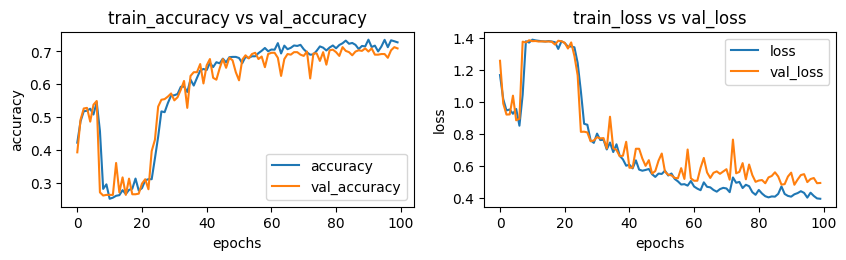

In [29]:
plot_accuracy_loss(history)

In [30]:
# Menghitung akurasi model pada data uji
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7215 - loss: 0.4807
Test Loss: 0.4944627285003662
Test Accuracy: 0.7091254591941833


In [31]:
import librosa
from tensorflow.keras.models import load_model
import IPython.display as ipd


model = load_model('./saved_models/audio_classification.keras')
filename = "./musical_instruments_dataset/Test_submission/Test_submission/ROOM_room6_MUS_mozart_DEV_redmi.wav"


# Ekstraksi fitur dari file audio yang akan diprediksi
pred_features = Feature_extractor(filename)

# Normalisasi fitur yang diekstraksi menggunakan scaler yang sama
pred_features_normalized = scaler.transform(pred_features)

# Lakukan prediksi dengan model yang dimuat
predictions = model.predict(pred_features_normalized)
predicted_label = np.argmax(predictions, axis=-1)
prediction_class = label_encoder.inverse_transform(predicted_label)[0]

print(f'Prediction class: {prediction_class}')
ipd.Audio(filename)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

c:\Users\Tazkiiia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Prediction class: Sound_Piano
